## Initialization

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to use the same matplotlib backend as Jupyter uses, so any GUI will shown
%matplotlib inline

# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Imbalance Dataset
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report #, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### User-defined Functions

In [2]:
def val_count(data:pd.Series, orderby:str='Count', ascending:bool=False) -> pd.DataFrame:
    '''
    Return a DataFrame containing counts of unique rows in Series

    Parameters
    ----------
    data: Series
        the data to be displayed value counts
    orderby: str (Count or Values)
        how to order the data, default Count
    ascending: bool (default: False)
        True for ascending, False for descending

    Returns
    ------
    DataFrame
        - Values : Values name
        - Count : Count per value
        - % : Percentage of count
    '''
    if type(data) == pd.Series:
        result = data.value_counts(dropna=False).reset_index() # without drop
        result.columns = ['Values', 'Count']
        result['%'] = np.around(result['Count'] * 100/len(data), 3)
        return result.sort_values(by=orderby, ascending=ascending)
    else:
        return 'Input Series only'

In [3]:
def numerical_summary(data: pd.Series, n: int = 3) -> pd.Series:
    '''
    Statistics summary for numerical data.

    Parameters
    ----------
    data : pandas series
        the data to be displayed in summary
    n : int, optional
        determine the number after the comma of the result
    '''

    # central tendency: mean, median
    mean = np.mean(data)
    median = np.median(data)

    # # distribution: std, min, max, range, skew, kurtosis
    std = np.std(data)
    min_value = np.min(data)
    max_value = np.max(data)
    range_value = np.abs(max_value - min_value)
    skewness = data.skew()
    kurtosis = data.kurtosis()

    # # concatenates
    result = pd.Series([min_value, max_value, range_value, mean, median, std, skewness, kurtosis])
    result.index = ['min','max', 'range','mean','median',  'std','skewness','kurtosis']

    return np.around(result, n)
    # return mean

## Data Collecting

In [4]:
path = './dataset/Dataset of Diabetes.csv'
data = pd.read_csv(path)
data

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,200,454317,M,71,11.0,97,7.0,7.5,1.7,1.2,1.8,0.6,30.0,Y
996,671,876534,M,31,3.0,60,12.3,4.1,2.2,0.7,2.4,15.4,37.2,Y
997,669,87654,M,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4,Y
998,99,24004,M,38,5.8,59,6.7,5.3,2.0,1.6,2.9,14.0,40.5,Y


## Data Cleaning and Preprocessing

### Removing Unnecessary Data

In [5]:
print(f'Columns Before ({len(data.columns)}):', data.columns.tolist())
data.drop(['ID','No_Pation'], axis=1, inplace=True)
print(f'Columns After ({len(data.columns)}):', data.columns.tolist())

Columns Before (14): ['ID', 'No_Pation', 'Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']
Columns After (12): ['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS']


### Correcting Data Entry Errors

In [6]:
print('# Before')
for col in data.select_dtypes('object').columns:
    print(f'{col}: {data[col].unique().tolist()}')

# Before
Gender: ['F', 'M', 'f']
CLASS: ['N', 'N ', 'P', 'Y', 'Y ']


In [7]:
data['Gender'] =  data['Gender'].replace({'f': 'F'})
data['CLASS'] =  data['CLASS'].replace({'N ': 'N', 'P': 'Y', 'Y ': 'Y'})

In [8]:
print('# After')
for col in data.select_dtypes('object').columns:
    print(f'{col}: {data[col].unique().tolist()}')

# After
Gender: ['F', 'M']
CLASS: ['N', 'Y']


### Handling Missing Value

In [9]:
data.isna().sum()

Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
CLASS     0
dtype: int64

### Dealing with Duplicate Records

In [10]:
print('Records Before:', len(data))
data = data.drop_duplicates().reset_index(drop=True)
print('Records After:', len(data))

Records Before: 1000
Records After: 826


### Data Transformation

#### Encode Gender

In [11]:
print('Before:', data['Gender'].unique().tolist())
data['Gender'].replace({'F': 0, 'M': 1}, inplace=True)
print('After:', data['Gender'].unique().tolist())

Before: ['F', 'M']
After: [0, 1]


C:\Users\acer\AppData\Local\Temp\ipykernel_26468\3497311812.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Gender'].replace({'F': 0, 'M': 1}, inplace=True)
C:\Users\acer\AppData\Local\Temp\ipykernel_26468\3497311812.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'].replac

#### Encode CLASS

In [12]:
print('Before:', data['CLASS'].unique().tolist())
data['CLASS'].replace({'N': 0, 'Y': 1}, inplace=True)
print('After:', data['CLASS'].unique().tolist())

Before: ['N', 'Y']
After: [0, 1]


C:\Users\acer\AppData\Local\Temp\ipykernel_26468\2182828091.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['CLASS'].replace({'N': 0, 'Y': 1}, inplace=True)
C:\Users\acer\AppData\Local\Temp\ipykernel_26468\2182828091.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['CLASS'].replace(

## Data Exploration

### Univariate Analysis (Categorical)

#### Gender

In [13]:
gender = val_count(data.Gender)
gender.style.hide(axis='index')

Values,Count,%
1,463,56.053000
0,363,43.947000


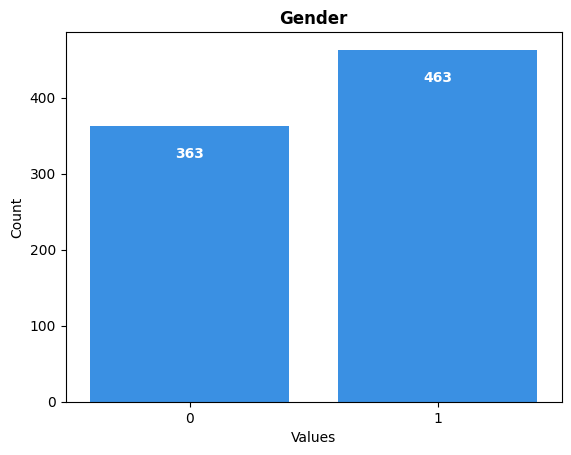

In [14]:
ax = sns.barplot(data=gender, x='Values', y='Count', color='dodgerblue')
ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
plt.title('Gender', fontweight='bold')
plt.show()

### Univariate Analysis (Numerical)

#### AGE

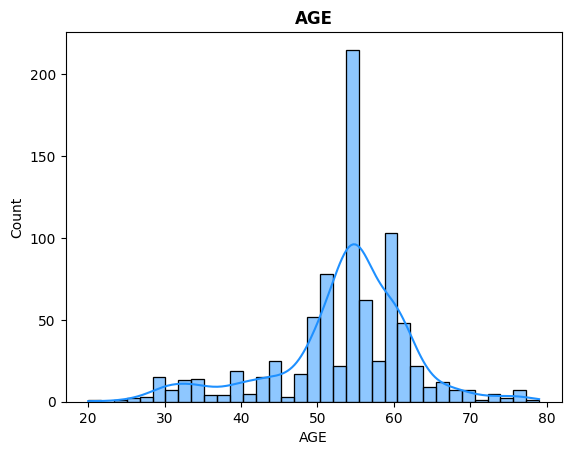

In [15]:
sns.histplot(data['AGE'], kde=True, color='dodgerblue')
plt.title('AGE', fontweight='bold')
plt.show()

In [16]:
numerical_summary(data['AGE'])

min         20.000
max         79.000
range       59.000
mean        53.490
median      55.000
std          8.803
skewness    -0.811
kurtosis     1.446
dtype: float64

#### Urea

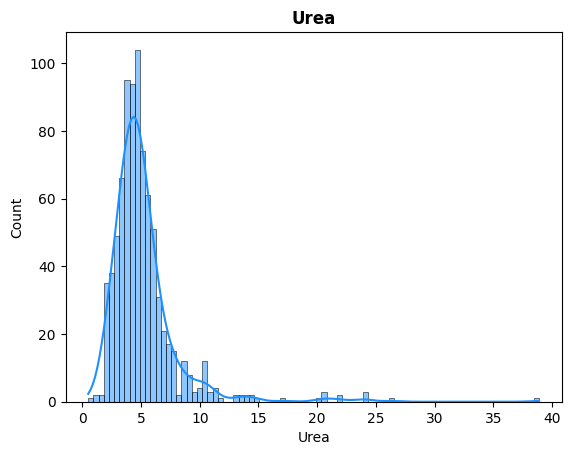

In [17]:
sns.histplot(data['Urea'], kde=True, color='dodgerblue')
plt.title('Urea', fontweight='bold')
plt.show()

In [18]:
numerical_summary(data['Urea'])

min          0.500
max         38.900
range       38.400
mean         5.185
median       4.600
std          3.076
skewness     4.259
kurtosis    29.197
dtype: float64

#### Cr

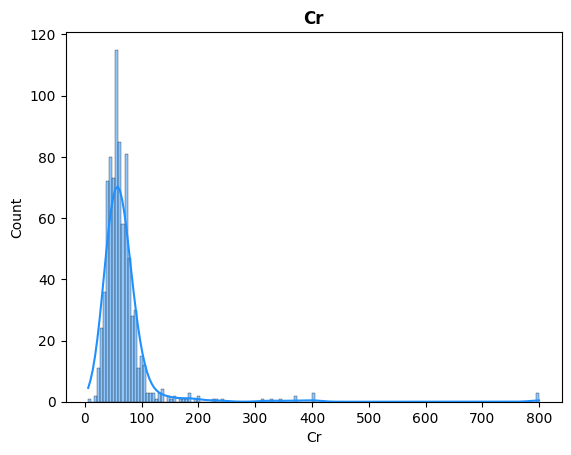

In [19]:
sns.histplot(data['Cr'], kde=True, color='dodgerblue')
plt.title('Cr', fontweight='bold')
plt.show()

In [20]:
numerical_summary(data['Cr'])

min           6.000
max         800.000
range       794.000
mean         69.024
median       59.000
std          59.521
skewness      8.149
kurtosis     87.035
dtype: float64

#### HbA1c

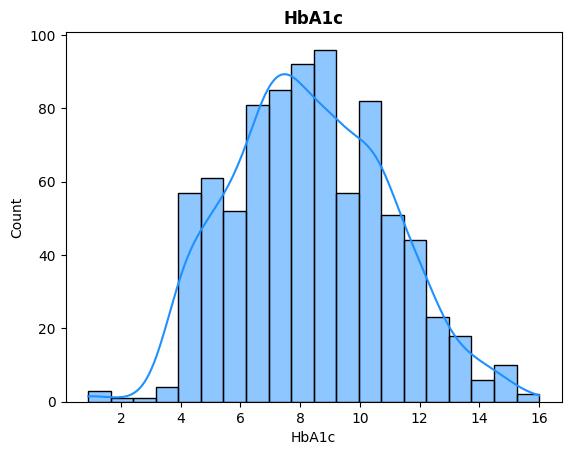

In [21]:
sns.histplot(data['HbA1c'], kde=True, color='dodgerblue')
plt.title('HbA1c', fontweight='bold')
plt.show()

In [22]:
numerical_summary(data['HbA1c'])

min          0.900
max         16.000
range       15.100
mean         8.326
median       8.100
std          2.601
skewness     0.183
kurtosis    -0.340
dtype: float64

#### Chol

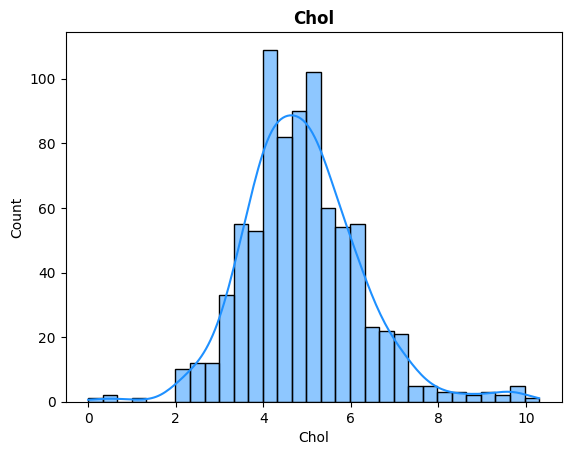

In [23]:
sns.histplot(data['Chol'], kde=True, color='dodgerblue')
plt.title('Chol', fontweight='bold')
plt.show()

In [24]:
numerical_summary(data['Chol'])

min          0.000
max         10.300
range       10.300
mean         4.898
median       4.800
std          1.328
skewness     0.576
kurtosis     1.696
dtype: float64

#### TG

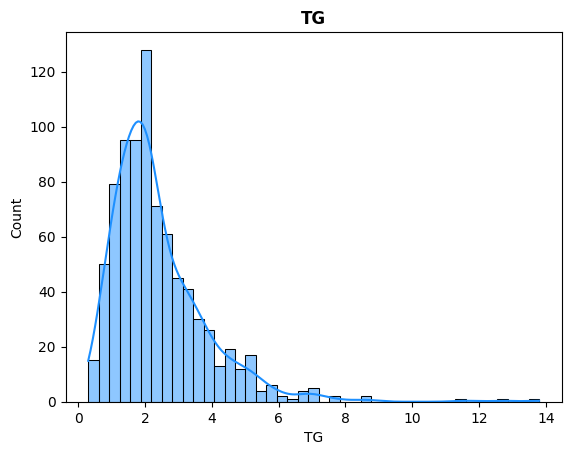

In [25]:
sns.histplot(data['TG'], kde=True, color='dodgerblue')
plt.title('TG', fontweight='bold')
plt.show()

In [26]:
numerical_summary(data['TG'])

min          0.300
max         13.800
range       13.500
mean         2.399
median       2.015
std          1.456
skewness     2.295
kurtosis    10.144
dtype: float64

#### HDL

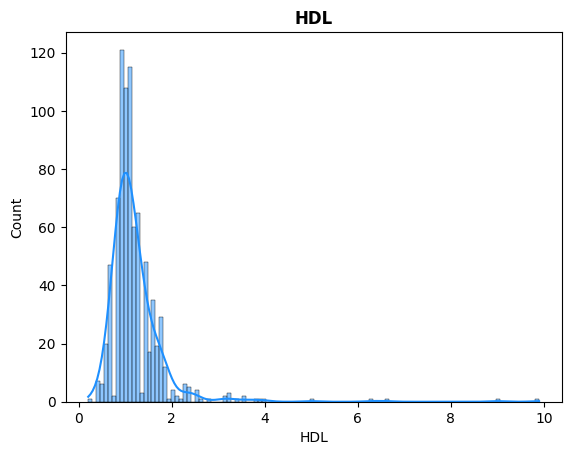

In [27]:
sns.histplot(data['HDL'], kde=True, color='dodgerblue')
plt.title('HDL', fontweight='bold')
plt.show()

In [28]:
numerical_summary(data['HDL'])

min          0.200
max          9.900
range        9.700
mean         1.212
median       1.100
std          0.679
skewness     6.298
kurtosis    62.700
dtype: float64

#### LDL

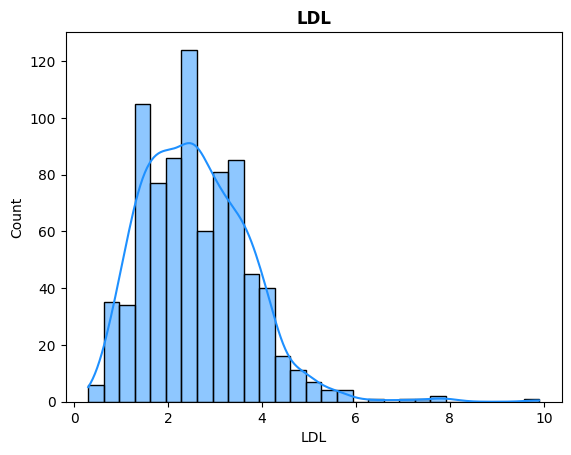

In [29]:
sns.histplot(data['LDL'], kde=True, color='dodgerblue')
plt.title('LDL', fontweight='bold')
plt.show()

In [30]:
numerical_summary(data['LDL'])

min         0.300
max         9.900
range       9.600
mean        2.590
median      2.500
std         1.132
skewness    1.005
kurtosis    3.023
dtype: float64

#### VLDL

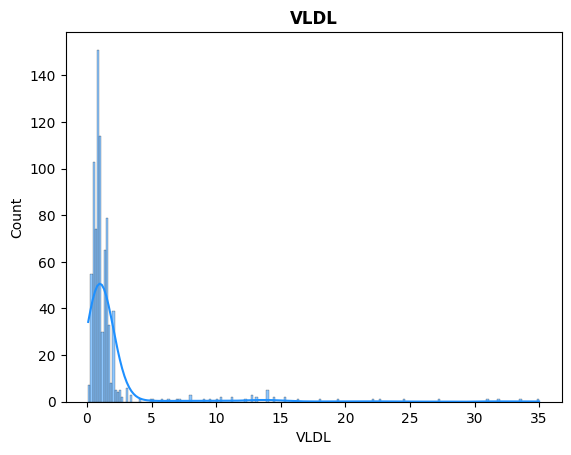

In [31]:
sns.histplot(data['VLDL'], kde=True, color='dodgerblue')
plt.title('VLDL', fontweight='bold')
plt.show()

In [32]:
numerical_summary(data['VLDL'])

min          0.100
max         35.000
range       34.900
mean         1.775
median       1.000
std          3.516
skewness     5.893
kurtosis    40.185
dtype: float64

#### BMI

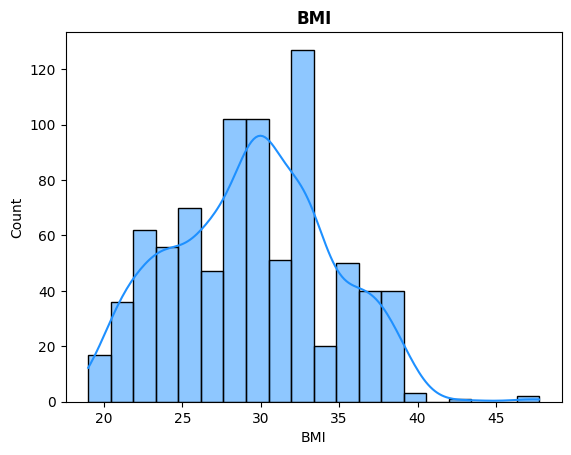

In [33]:
sns.histplot(data['BMI'], kde=True, color='dodgerblue')
plt.title('BMI', fontweight='bold')
plt.show()

In [34]:
numerical_summary(data['BMI'])

min         19.000
max         47.750
range       28.750
mean        29.459
median      30.000
std          4.994
skewness     0.081
kurtosis    -0.425
dtype: float64

### Correlation

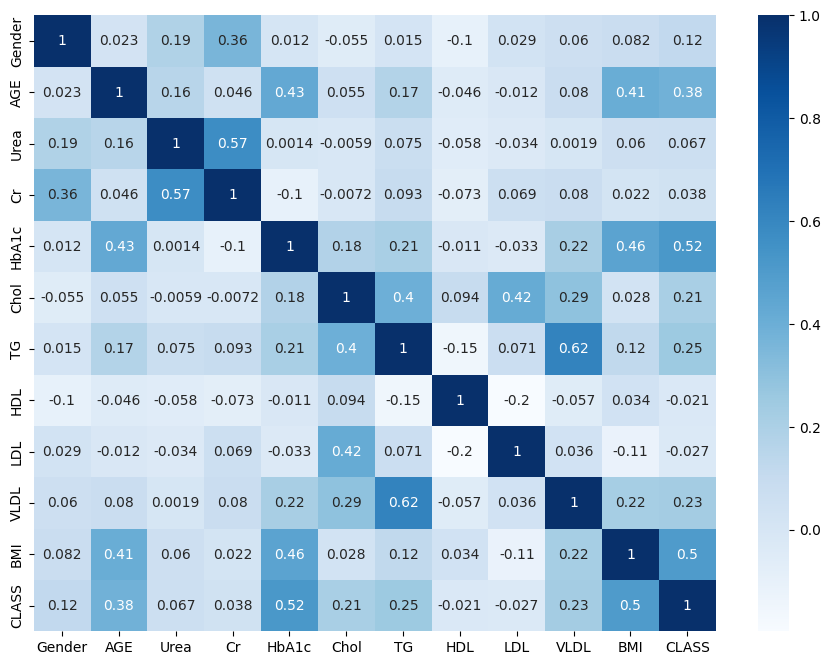

In [35]:
plt.figure(figsize=(11,8))
sns.heatmap(data.corr(method='spearman'), annot=True, cmap='Blues')
plt.show()

In [36]:
corr_with_target = data.drop('CLASS', axis=1).corrwith(data['CLASS'],axis=0, method='spearman')
corr_with_target = corr_with_target.sort_values(key=abs, ascending=False).reset_index()
corr_with_target = corr_with_target.rename(columns={'index':'Feature', 0:'Corr'})
print('Sorted Correlation Between Feature and Target(CLASS)\n')
display(corr_with_target.style.hide(axis='index'))

Sorted Correlation Between Feature and Target(CLASS)



Feature,Corr
HbA1c,0.521619
BMI,0.502826
AGE,0.383285
TG,0.253221
VLDL,0.231634
Chol,0.212505
Gender,0.120338
Urea,0.067122
Cr,0.038377
LDL,-0.026866


### Label Distributions

In [37]:
class_ = val_count(data.CLASS)
class_.style.hide(axis='index')

Values,Count,%
1,730,88.378000
0,96,11.622000


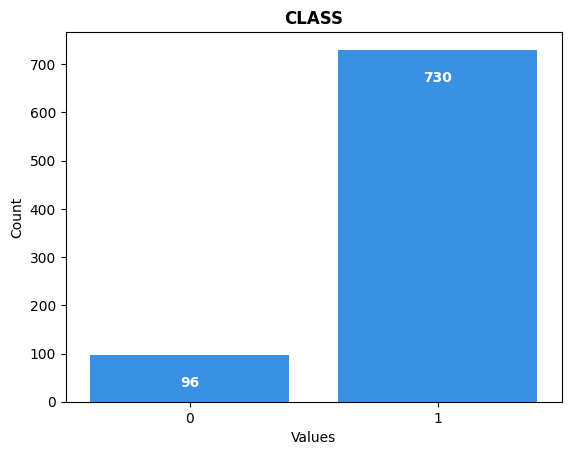

In [38]:
ax = sns.barplot(data=class_, x='Values', y='Count', color='dodgerblue')
ax.bar_label(ax.containers[0], fmt='%i', padding=-25, color='white', fontweight='bold')
plt.title('CLASS', fontweight='bold')
plt.show()

## Feature Engineering

### Normalizing

In [39]:
norm_col = ['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[norm_col])
data_scaled = pd.DataFrame(data_scaled, columns=norm_col)
data = pd.concat([data_scaled, data[['Gender', 'CLASS']]], axis=1)
data

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,Gender,CLASS
0,0.508475,0.109375,0.050378,0.264901,0.407767,0.044444,0.226804,0.114583,0.011461,0.173913,0,0
1,0.101695,0.104167,0.070529,0.264901,0.359223,0.081481,0.092784,0.187500,0.014327,0.139130,1,0
2,0.220339,0.171875,0.050378,0.264901,0.475728,0.051852,0.061856,0.177083,0.008596,0.069565,1,0
3,0.423729,0.046875,0.022670,0.205298,0.281553,0.051852,0.082474,0.125000,0.008596,0.069565,0,0
4,0.508475,0.039062,0.055416,0.205298,0.349515,0.074074,0.072165,0.187500,0.014327,0.173913,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.627119,0.093750,0.080605,0.556291,0.514563,0.222222,0.082474,0.114583,0.034384,0.347826,0,1
822,0.593220,0.067708,0.041562,0.503311,0.485437,0.162963,0.175258,0.270833,0.017192,0.278261,1,1
823,0.135593,0.078125,0.069270,0.503311,0.436893,0.118519,0.092784,0.239583,0.020057,0.626087,1,1
824,0.830508,0.255208,0.225441,0.450331,0.475728,0.118519,0.103093,0.281250,0.017192,0.626087,1,1


### Train-Test Split

In [40]:
X = data.drop('CLASS', axis=1)
y = data['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# X_train.shape, X_test.shape

print('Jumlah Baris Data Latih:', len(X_train))
print('Jumlah Baris Data Uji:', len(X_test))

Jumlah Baris Data Latih: 660
Jumlah Baris Data Uji: 166


### Resampling Data for Imbalance Dataset

In [41]:
# Initialize & fit resample
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_SMOTE, y_SMOTE = smote.fit_resample(X_train, y_train)

# Counting labels
sampler_count = [['Original Data', y_train], ['SMOTE', y_SMOTE]]

# Print results
for i in sampler_count:
    print(i[0])
    display(val_count(pd.Series(i[1])))

Original Data


,Values,Count,%
0,1,583,88.333
1,0,77,11.667


SMOTE


,Values,Count,%
0,1,583,66.705
1,0,291,33.295


## Modeling

### Model Fit & Predict

In [42]:
# Initialize resampling data
resample = [
    ('Original', X_train, y_train),
    ('SMOTE', X_SMOTE, y_SMOTE)
]

# Initialize models
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

# Evaluate models
results = []

# Fit & Predict
for r_name, X, y in resample:
    for m_name, model in models:
        model.fit(X, y)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append((r_name+' - '+m_name, accuracy, precision, recall, f1))

## Evaluation

In [43]:
# Create comparison table
comparison = pd.DataFrame(results, columns=['Model', 'Accuracy','Precision',
                                            'Recall', 'F1 Score'])
comparison = comparison.set_index(['Model'])
comparison.index.name = None

# Print sorted comparison table
comparison.reindex(comparison.mean(axis=1).sort_values(ascending=False).index)

,Accuracy,Precision,Recall,F1 Score
SMOTE - Random Forest,1.000000,1.000000,1.000000,1.000000
SMOTE - Decision Tree,1.000000,1.000000,1.000000,1.000000
SMOTE - XGBoost,0.993976,0.993243,1.000000,0.996610
Original - XGBoost,0.987952,0.986577,1.000000,0.993243
Original - Random Forest,0.987952,0.986577,1.000000,0.993243
Original - Decision Tree,0.987952,0.993197,0.993197,0.993197
SMOTE - Logistic Regression,0.963855,0.986207,0.972789,0.979452
Original - Logistic Regression,0.939759,0.936306,1.000000,0.967105
